# Geoid undulations from topographic-isostaic masses using spherical harmonic and numerical integration

In [1]:
import numpy as np
import pyharm as ph
import os
from pyharmgrav import grid_sh_synthesis
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import subprocess
import io
import time

Topography, water depth, and ice thickness are taken from CRUST1.0 model , that has $1^{\circ} \times 1^{\circ}$ resolution. It contains additional crust layers, too, but they are not used in this simple example. From these rock-equivalent topography is computed first. \
It is computed with this formula if using planar approximation for layer $i$ [Kuhn - Hirt, 2016]:
$$
\Delta h_{eq}^{i} = h \frac{\rho}{\rho_0} \Delta H = h \frac{\rho}{\rho_0} (H_{up}-H_{low})
$$
With spherical approximation:
$$
\Delta h_{eq}^{i} = \sqrt[3]{\frac{\rho}{\rho_0} (R_{up}^{3}-R_{low}^{3}) + R_{low}^{3}} - R_{low}^{3}
$$
where
$$
R_{up} = R + H_{up}
$$
$$
R_{low} = R + H_{low}
$$
The fianal rock-equivalent topography:
$$
h_{eq} = h + \sum{\Delta h_{eq}^{i}}
$$
In the Airy-Heiskannen model crust is assumed to have constant density, but variable thickness, where highly elevated terrain is compensated by thick crust, low terrain and oceans are compensated by thin crust. The density on which the crust floats, also considered constant. Here crust density is assumed to be $2670\ kg/m^3$, and $3300\ kg/m^3$ used for mantle. \
A relation for the variable root-thickness can be obtained from the condition of floating equilibrium. With planar approximation [Tsoulis,1999]:
$$
t = \frac{\rho_{cr}}{\Delta \rho} h_{eq}
$$
$$
\Delta \rho = \rho_m - \rho_{cr}
$$
With spherical approximation:
$$
t = \left( \frac{R}{R-D} \right)^2 \frac{\rho_{cr}}{\Delta \rho} h_{eq}
$$

In [2]:
input_folder = r'C:\PHD\2024_25_2\CRUST1.0\maps'

water_layer_path = os.path.join(input_folder,'map-bd1')
ice_layer_path = os.path.join(input_folder,'map-bd2')
topo_layer_path = os.path.join(input_folder,'map-bd3')

water_layer_top = np.loadtxt(water_layer_path)*1000
ice_layer_top = np.loadtxt(ice_layer_path)*1000
topo_layer = np.loadtxt(topo_layer_path)*1000

Re = 6371000
rho_cr = 2670
rho_w = 1020
rho_i = 920
rho_m = 3300
GM = 3986004.418e8
G = 6.673e-11
nmax = 179
grid_res = 1
D  = 30000 # compensation depth
delta_rho = rho_m - rho_cr
# rock-equivalent topography (RET) in spherical approximation
# RET - water
r_uw = Re + water_layer_top
r_lw = Re + ice_layer_top
deltaH_w = (rho_w/rho_cr*(r_uw**3-r_lw**3) + r_lw**3)**(1/3) - r_lw
# RET - ice
r_ui = Re + ice_layer_top
r_li = Re + topo_layer
deltaH_i = (rho_i/rho_cr*(r_ui**3-r_li**3) + r_li**3)**(1/3) - r_li
h_eq = topo_layer + deltaH_w + deltaH_i
# grid definition
latmin = np.radians(np.arange(90-grid_res,-90-grid_res/2,-1*grid_res))
latmax = np.radians(np.arange(90,-90+grid_res/2,-1*grid_res))
lonmin = np.radians(np.arange(0,360-grid_res/2,grid_res))
lonmax = np.radians(np.arange(0+grid_res,360+grid_res/2,grid_res))
radius = np.ones(len(latmin))
# convert data: h_eq is from latitude -180 to 180, not 0 to 360
nlon = h_eq.shape[1]
half = nlon // 2
h_eqr =  np.roll(h_eq, shift=half, axis=1)
#topo_layer_r = np.roll(topo_layer, shift=half, axis=1)

# Computing geoid with sperical harmonics
Spherical harmonic coefficients of topography [Tsoulis,1999]:
$$
\begin{matrix}
\overline{C}_{nm}^{T}\\
\overline{S}_{nm}^{T}
\end{matrix} \Bigg\}=
\frac{3}{2n+1} \frac{\rho_{cr}}{\overline{\rho}} \left\{ h_{nm} + \frac{n+2}{2}\ h2_{nm} + \frac{(n+2)(n+1)}{6}\ h3_{nm}   \right\}
$$
where
$$
h_{nm} = \frac{1}{4 \pi} \iint\limits_{\sigma} \frac{h}{R} \ \overline{P}_{nm}(\cos{\theta})
\begin{Bmatrix}
\cos{m \lambda}\\
\sin{m \lambda}
\end{Bmatrix} d \sigma
$$
$$
h2_{nm} = \frac{1}{4 \pi} \iint\limits_{\sigma} \left( \frac{h}{R} \right)^2 \  \overline{P}_{nm}(\cos{\theta})
\begin{Bmatrix}
\cos{m \lambda}\\
\sin{m \lambda}
\end{Bmatrix} d \sigma
$$
$$
h3_{nm} = \frac{1}{4 \pi} \iint\limits_{\sigma} \left( \frac{h}{R} \right)^3 \  \overline{P}_{nm}(\cos{\theta})
\begin{Bmatrix}
\cos{m \lambda}\\
\sin{m \lambda}
\end{Bmatrix} d \sigma
$$
Spherical harmonic coefficients of isostatic masses:
$$
\begin{matrix}
\overline{C}_{nm}^{C}\\
\overline{S}_{nm}^{C}
\end{matrix} \Bigg\}=
\frac{3}{2n+1} \frac{\rho_{cr}}{\overline{\rho}} 
\left\{ \left( \frac{R-D}{R}\right)^n h_{nm} - \frac{n+2}{2}\ \frac{\rho_{cr}}{\Delta \rho}  \left( \frac{R-D}{R}\right)^{n-3}  h2_{nm} + \frac{(n+2)(n+1)}{6}\  \frac{\rho_{cr}^2}{{\Delta \rho}^2} \left( \frac{R-D}{R}\right)^{n-6} h3_{nm}   \right\}
$$
The coefficients of isostatically compensated topography:
$$
\begin{Bmatrix}
\overline{C}_{nm}\\
\overline{S}_{nm}
\end{Bmatrix} =
\begin{Bmatrix}
\overline{C}_{nm}^{T}\\
\overline{S}_{nm}^{T}
\end{Bmatrix} -
\begin{Bmatrix}
\overline{C}_{nm}^{C}\\
\overline{S}_{nm}^{C}
\end{Bmatrix}
$$

2670
5514.488385128208
Spherical harmonic analysis: 0.03086 s


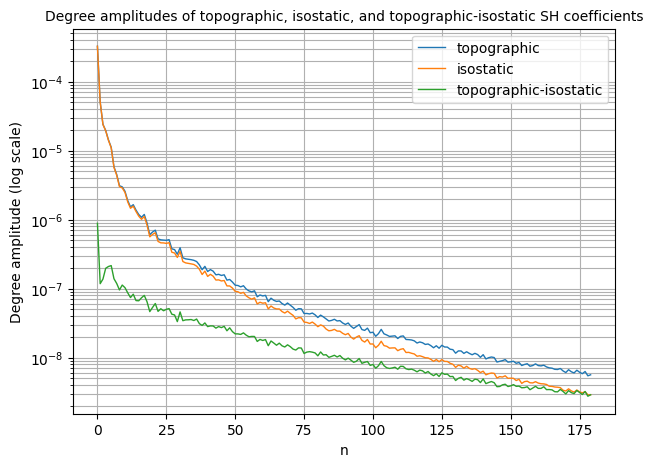

In [3]:
start_t = time.time()
grd    = ph.crd.CellGrid.from_arrays(latmin, latmax, lonmin, lonmax, radius)


h_coeffs1 = ph.sha.cell(grd,(h_eqr/Re),nmax,ph.sha.CELL_AQ,1,1)
h_coeffs2 = ph.sha.cell(grd,(h_eqr**2/Re**2),nmax,ph.sha.CELL_AQ,1,1)
h_coeffs3 = ph.sha.cell(grd,(h_eqr**3/Re**3),nmax,ph.sha.CELL_AQ,1,1)

# extract coefficients and indexes
index = np.arange(0,nmax+1,1)
n, m = np.meshgrid(index, index,indexing='ij')
n[n < m] = -1

n = n.flatten(order='F')
m = m.flatten(order='F')
cond = (n >= 0)
n = n[cond]
m = m[cond]

rhoE = 3*GM/(4*np.pi*G*Re**3)
print(rho_cr)
print(rhoE)

C_nmT = 3/(2*n+1)*rho_cr/rhoE * (  h_coeffs1.c + (n+2)/2 * h_coeffs2.c + (n+2)*(n+1)/6 * h_coeffs3.c)
S_nmT = 3/(2*n+1)*rho_cr/rhoE * (  h_coeffs1.s + (n+2)/2 * h_coeffs2.s + (n+2)*(n+1)/6 * h_coeffs3.s)

C_nmC = 3/(2*n+1)*rho_cr/rhoE * ( ((Re-D)/Re)**n * h_coeffs1.c - (n+2)/2*rho_cr/delta_rho*((Re-D)/Re)**(n-3) * h_coeffs2.c \
        + (n+2)*(n+1)/6*(rho_cr/delta_rho)**2*((Re-D)/Re)**(n-6) * h_coeffs3.c)
S_nmC = 3/(2*n+1)*rho_cr/rhoE * ( ((Re-D)/Re)**n * h_coeffs1.s - (n+2)/2*rho_cr/delta_rho*((Re-D)/Re)**(n-3) * h_coeffs2.s \
        + (n+2)*(n+1)/6*(rho_cr/delta_rho)**2*((Re-D)/Re)**(n-6) * h_coeffs3.s)

C_nm = C_nmT - C_nmC
S_nm = S_nmT - S_nmC

table = np.vstack((n,m,C_nm,S_nm)).T
end_t = time.time()
duration = end_t - start_t
print(f'Spherical harmonic analysis: {duration:.5f} s')
np.savetxt('./output/Airy_coeffs.dat',table,fmt='%d %d %.12e %.12e')

topo_coeffs = ph.shc.Shc.from_arrays(nmax,C_nmT,S_nmT,mu=float(GM),r=float(Re))
topo_da =topo_coeffs.da()
iso_coeffs = ph.shc.Shc.from_arrays(nmax,C_nmC,S_nmC,mu=float(GM),r=float(Re))
iso_da =iso_coeffs.da()
topoiso_coeffs = ph.shc.Shc.from_arrays(nmax,C_nm,S_nm,mu=float(GM),r=float(Re))
topoiso_da = topoiso_coeffs.da()
fig,ax = plt.subplots(figsize=(7,5))
plt.title('Degree amplitudes of topographic, isostatic, and topographic-isostatic SH coefficients',fontsize=10)
ax.semilogy(np.arange(0,180),topo_da,linewidth=1)
ax.semilogy(np.arange(0,180),iso_da,linewidth=1)
ax.semilogy(np.arange(0,180),topoiso_da,linewidth=1)
ax.set_ylabel('Degree amplitude (log scale)')
ax.set_xlabel('n')
plt.legend(['topographic','isostatic','topographic-isostatic'])
plt.grid(which='both')

Grid size: 180 x 360 = 64800 points
Spherical harmonic synthesis: 0.03945 s
Geoid min.:0.172 m,Geoid max.:32.290 m


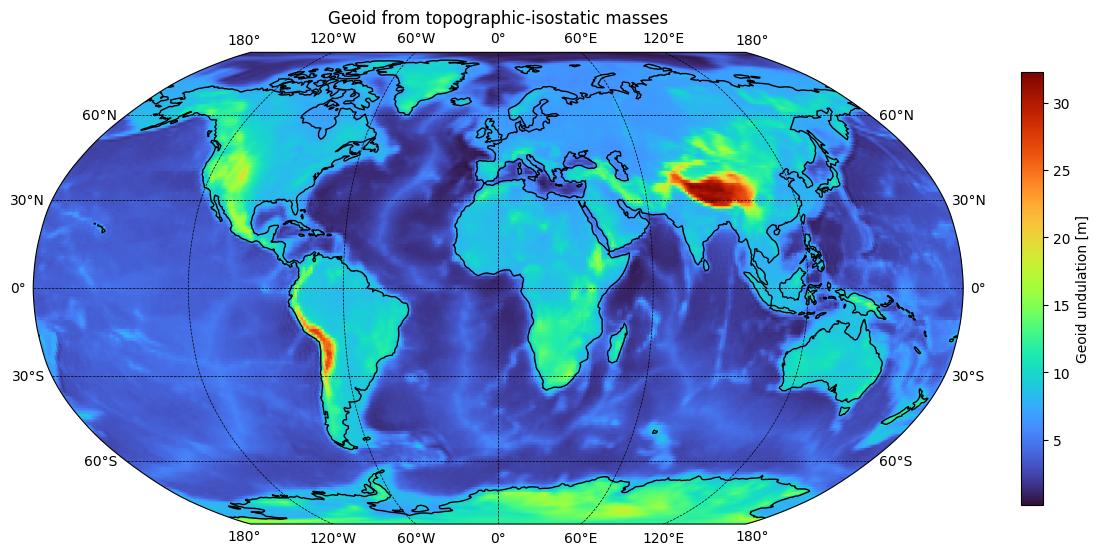

In [8]:
start_t = time.time()
geoid,_ = grid_sh_synthesis('zeta_ell',-89.5,89.5,-179.5,179.5,1,'./output/Airy_coeffs.dat','degrees',0,nmax,None,'dat','sphere',0,Re,GM,Re,None,None,True)
end_t = time.time()
duration = end_t - start_t
print(f'Spherical harmonic synthesis: {duration:.5f} s')
print(f'Geoid min.:{geoid.min():.3f} m,Geoid max.:{geoid.max():.3f} m')
fig = plt.figure(figsize=(15, 7.5))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_title('Geoid from topographic-isostatic masses')

img=ax.imshow(geoid,cmap='turbo',transform=ccrs.PlateCarree())
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.5, color='black', linestyle='--',\
        x_inline=False,y_inline=False)
_=ax.coastlines('110m')
cbar=fig.colorbar(img,shrink = 0.75)
cbar.set_label('Geoid undulation [m]')

# Comparing to real geoid
Computing geoid (without topographic correction) using EIGEN-6C4 geopotential model

Grid size: 180 x 360 = 64800 points
Geoid min.:-107.186 m,Geoid max.:83.810 m


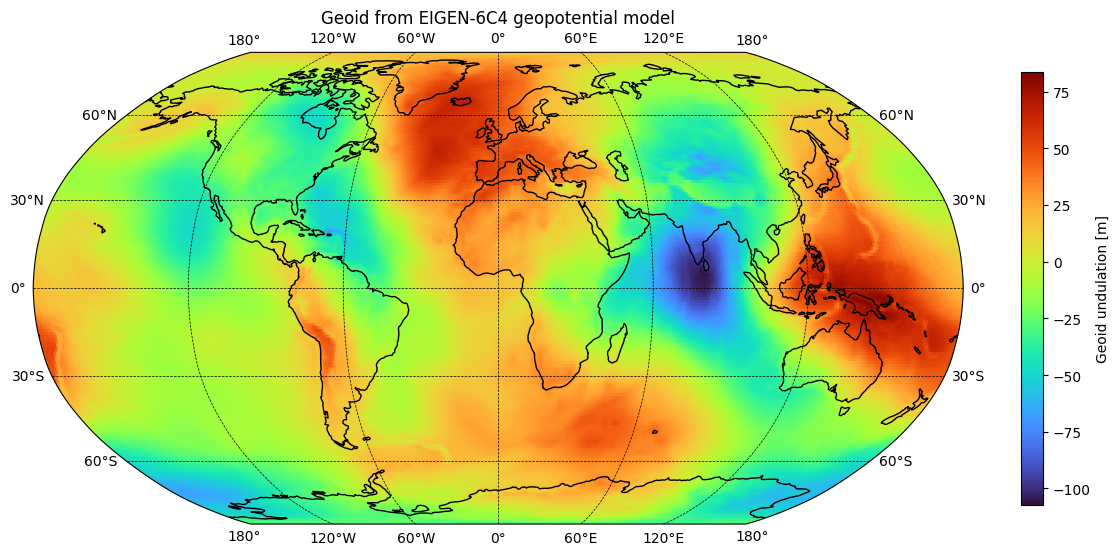

In [5]:
geoid0,_ = grid_sh_synthesis('zeta_ell',-89.5,89.5,-179.5,179.5,1,'./input_data/EIGEN-6C4.gfc','degrees',0,nmax,'GRS80',None,'ellipsoid',0,None,None,None,None,None,False)
print(f'Geoid min.:{geoid0.min():.3f} m,Geoid max.:{geoid0.max():.3f} m')
fig = plt.figure(figsize=(15, 7.5))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_title('Geoid from EIGEN-6C4 geopotential model')

img=ax.imshow(geoid0,cmap='turbo',transform=ccrs.PlateCarree())
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.5, color='black', linestyle='--',\
        x_inline=False,y_inline=False)
_=ax.coastlines('110m')
cbar=fig.colorbar(img,shrink = 0.75)
cbar.set_label('Geoid undulation [m]')

# Computing geoid with tesseroid numerical integration
I used the software Tesseroids [Uieda - Barbosa - Braitenberg, 2016] for numerical integration of topographic and isostatic potential. It is open-source software, accessible here: https://github.com/leouieda/tesseroids . Program 'tessmodegen' was used to create the tesseroid model from grid of rock-equivalent heights computed before, 'tessgrd' to create a regular grid at 10 000 m elevation (because integration inside mass elements is invalid, and 10 000 m is safely above topography everywhere) , and 'tesspot' to compute potential.<br>Tesseroids was designed with the Unix philosophy in mind. Therefore, all tessg* programs and tessgrd can be piped together to calculate many components on a regular grid.

In [6]:
# grid definition
latitudes = np.arange(90,-90+grid_res/2,-1*grid_res) - grid_res/2
longitudes = np.arange(-180,180-grid_res/2,grid_res) + grid_res/2
lat_size = len(latitudes)
lon_size = len(longitudes)
latitudes_grd , longitudes_grd = np.meshgrid(latitudes,longitudes, indexing='ij')
def s2hms(sec):
    h = int(np.floor(sec/3600))
    m = int(np.floor((sec/3600-h)*60))
    s = ((sec/3600-h)*60 - m)*60
    return [h,m,s]

### Topographic potential with numerical integration

In [7]:
def xyz2grid(array):
    lon_tess, lat_tess, pot_tess = array[:,0],array[:,1],array[:,3]
    lons = sorted(list(set(lon_tess)))
    lats = sorted(list(set(lat_tess)))
    nx = len(lons)
    ny = len(lats)
    grid_topo_pot = np.full((ny, nx), np.nan)
    # Fill matrix
    for lo, la, val in zip(lon_tess, lat_tess, pot_tess):
        ix = lons.index(lo)
        iy = lats.index(la)
        grid_topo_pot[iy, ix] = val
    grid_topo_pot = np.flipud(grid_topo_pot)
    return grid_topo_pot

start_t = time.time()
heq_xyz = np.vstack((longitudes_grd.ravel(),latitudes_grd.ravel(),h_eq.ravel())).T
buf = io.StringIO()
np.savetxt(buf,heq_xyz,fmt='%6.1f %6.1f %6.1f')
text = buf.getvalue()

p1 = subprocess.Popen(['tessmodgen', f'-s{grid_res}/{grid_res}','-z0',f'-d{rho_cr}'],stdin=subprocess.PIPE, stdout=subprocess.PIPE,stderr=subprocess.PIPE)
out, err = p1.communicate(text.encode())
modelfile = './input_data/tesseroid_model/tesseroid_model_topo.txt'
with open(modelfile,'wb') as f:
    f.write(out)

result=subprocess.run(f'tessgrd -r{-180+grid_res/2}/{180-grid_res/2}/{-90+grid_res/2}/{90-grid_res/2} -b{lon_size}/{lat_size} -z10000 | tesspot {modelfile}',shell=True,capture_output=True)
result_io = io.StringIO(result.stdout.decode())
result_array = np.loadtxt(result_io)
grid_topo_pot = xyz2grid(result_array)
end_t = time.time()
duration = end_t - start_t
duration_hms = s2hms(duration)
print(f'Numerical integration for topographic masses: {duration_hms[0]:02d}:{duration_hms[1]:02d}:{duration_hms[2]:.3f}')

Numerical integration for topographic masses: 00:48:43.841


### Isostatic potential with numerical integration

In [10]:
start_t = time.time()
t = (Re/(Re-D))**2 * rho_cr /delta_rho * h_eq
depth = -1*D
iso_surf = depth - t
heq_xyz = np.vstack((longitudes_grd.ravel(),latitudes_grd.ravel(),iso_surf.ravel())).T
buf = io.StringIO()
np.savetxt(buf,heq_xyz,fmt='%6.1f %6.1f %6.1f')
text = buf.getvalue()

p1 = subprocess.Popen(['tessmodgen', f'-s{grid_res}/{grid_res}',f'-z{depth}',f'-d{delta_rho}'],stdin=subprocess.PIPE, stdout=subprocess.PIPE,stderr=subprocess.PIPE)
out, err = p1.communicate(text.encode())
modelfile = './sample_input_data/tesseroid_model/tesseroid_model_iso.txt'
with open(modelfile,'wb') as f:
    f.write(out)
result=subprocess.run(f'tessgrd -r{-180+grid_res/2}/{180-grid_res/2}/{-90+grid_res/2}/{90-grid_res/2} -b{lon_size}/{lat_size} -z10000 | tesspot {modelfile}',shell=True,capture_output=True)
result_io = io.StringIO(result.stdout.decode())
result_array = np.loadtxt(result_io)
grid_iso_pot = xyz2grid(result_array)
end_t = time.time()
duration = end_t - start_t
duration_hms = s2hms(duration)
print(f'Numerical integration for topographic masses: {duration_hms[0]:02d}:{duration_hms[1]:02d}:{duration_hms[2]:.3f}')

Numerical integration for topographic masses: 00:48:34.007


### Constructing geoid from results of numerical integration

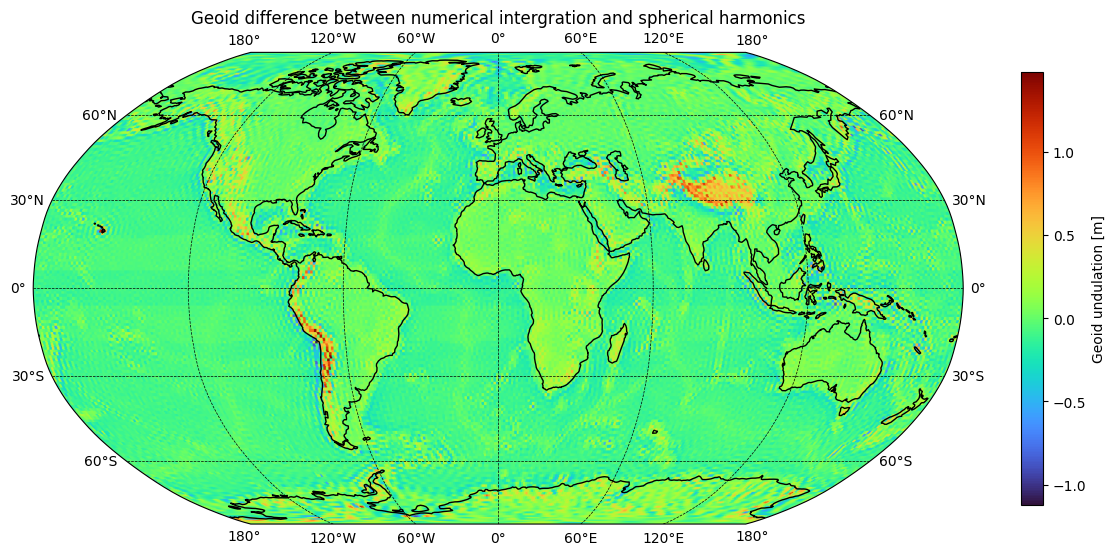

In [15]:
topoiso_pot = grid_topo_pot + grid_iso_pot
g = GM / Re**2 
topoiso_geoid_num = topoiso_pot / g
geoid_diff = geoid - topoiso_geoid_num
fig = plt.figure(figsize=(15, 7.5))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_title('Geoid difference between numerical intergration and spherical harmonics')
img=ax.imshow(geoid_diff,cmap='turbo',transform=ccrs.PlateCarree())
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.5, color='black', linestyle='--',\
        x_inline=False,y_inline=False)
_=ax.coastlines('110m')
cbar=fig.colorbar(img,shrink = 0.75)
cbar.set_label('Geoid undulation [m]')

# References
+ Kuhn,M.; Hirt,C. (2016):Topographic gravitational potential up to second-order
derivatives: an examination of approximation errors caused
by rock-equivalent topography (RET), Journal of Geodesy, DOI 10.1007/s00190-016-0917-6
+ Uieda, L., V. Barbosa, and C. Braitenberg (2016), Tesseroids: Forward-modeling gravitational fields in spherical coordinates, GEOPHYSICS, F41-F48, doi:10.1190/geo2015-0204.1.
+ Tsoulis, D. (1999): Spherical harmonic computations with topographic/isostatic
coefficients, Reports in the series IAPG/FESG, Rep. No. 3, Institute of
Astronomical and Physical Geodesy, Technical University of Munich,
33 pp.